In [131]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale, quantile_transform
from category_encoders import WOEEncoder

import catboost
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error


from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
sns.set_style("whitegrid")

# <b> <span style='color:#F1C40F'>|</span> Table of Contents</b>

* [1 | Missing Values](#1)<br>
* [2 | Plots](#2)
* [3 | Pre processing ](#3)<br>
* [4 | Model ](#5)<br>
    - [5.1 | CatBoost ](#51)<br>
    - [5.2 | Tensorflow ](#52)<br>

In [132]:
train = pd.read_csv('Data/3.3/train.csv')
test =  pd.read_csv('Data/3.3/test.csv')
sub =  pd.read_csv('Data/3.3/sample_submission.csv')
original =  pd.read_csv('Data/3.3/WA_Fn-UseC_-HR-Employee-Attrition.xls')

train.drop('id',axis=1, inplace=True)
test.drop('id',axis=1, inplace=True)
train = train.rename(columns={'Attrition':'target'})
original = train.rename(columns={'Attrition':'target'})

In [133]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,target
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


<a id="1"></a>
# <b>1 </b><b> <span style='color:#F1C40F'>|</span> Missing Values</b>

In [134]:
df_missing_train = pd.DataFrame(train.isna().sum()).rename(columns={0:'train'})
df_missing_test = pd.DataFrame(test.isna().sum()).rename(columns={0:'test'})
df_missing_original = pd.DataFrame(original.isna().sum()).rename(columns={0:'original'})
df_missing = pd.concat([df_missing_train, df_missing_test, df_missing_original], axis=1).fillna(0).astype({'test':int, 'original':int})
df_missing.head(len(train.columns.to_list()))
df_missing

,train,test,original
Age,0,0,0
BusinessTravel,0,0,0
DailyRate,0,0,0
Department,0,0,0
DistanceFromHome,0,0,0
Education,0,0,0
EducationField,0,0,0
EmployeeCount,0,0,0
EnvironmentSatisfaction,0,0,0
Gender,0,0,0


<a id="2"></a>
# <b>2 </b><b> <span style='color:#F1C40F'>|</span> Plots</b>

In [135]:
def histograms_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax)#,facecolor='blue')
        ax.set_title(feature+" Distribution",color='black')
    fig.tight_layout()  
    plt.show()

In [136]:
df_original = original[original['target']==1]
df = pd.concat([train, df_original,test], axis=0)

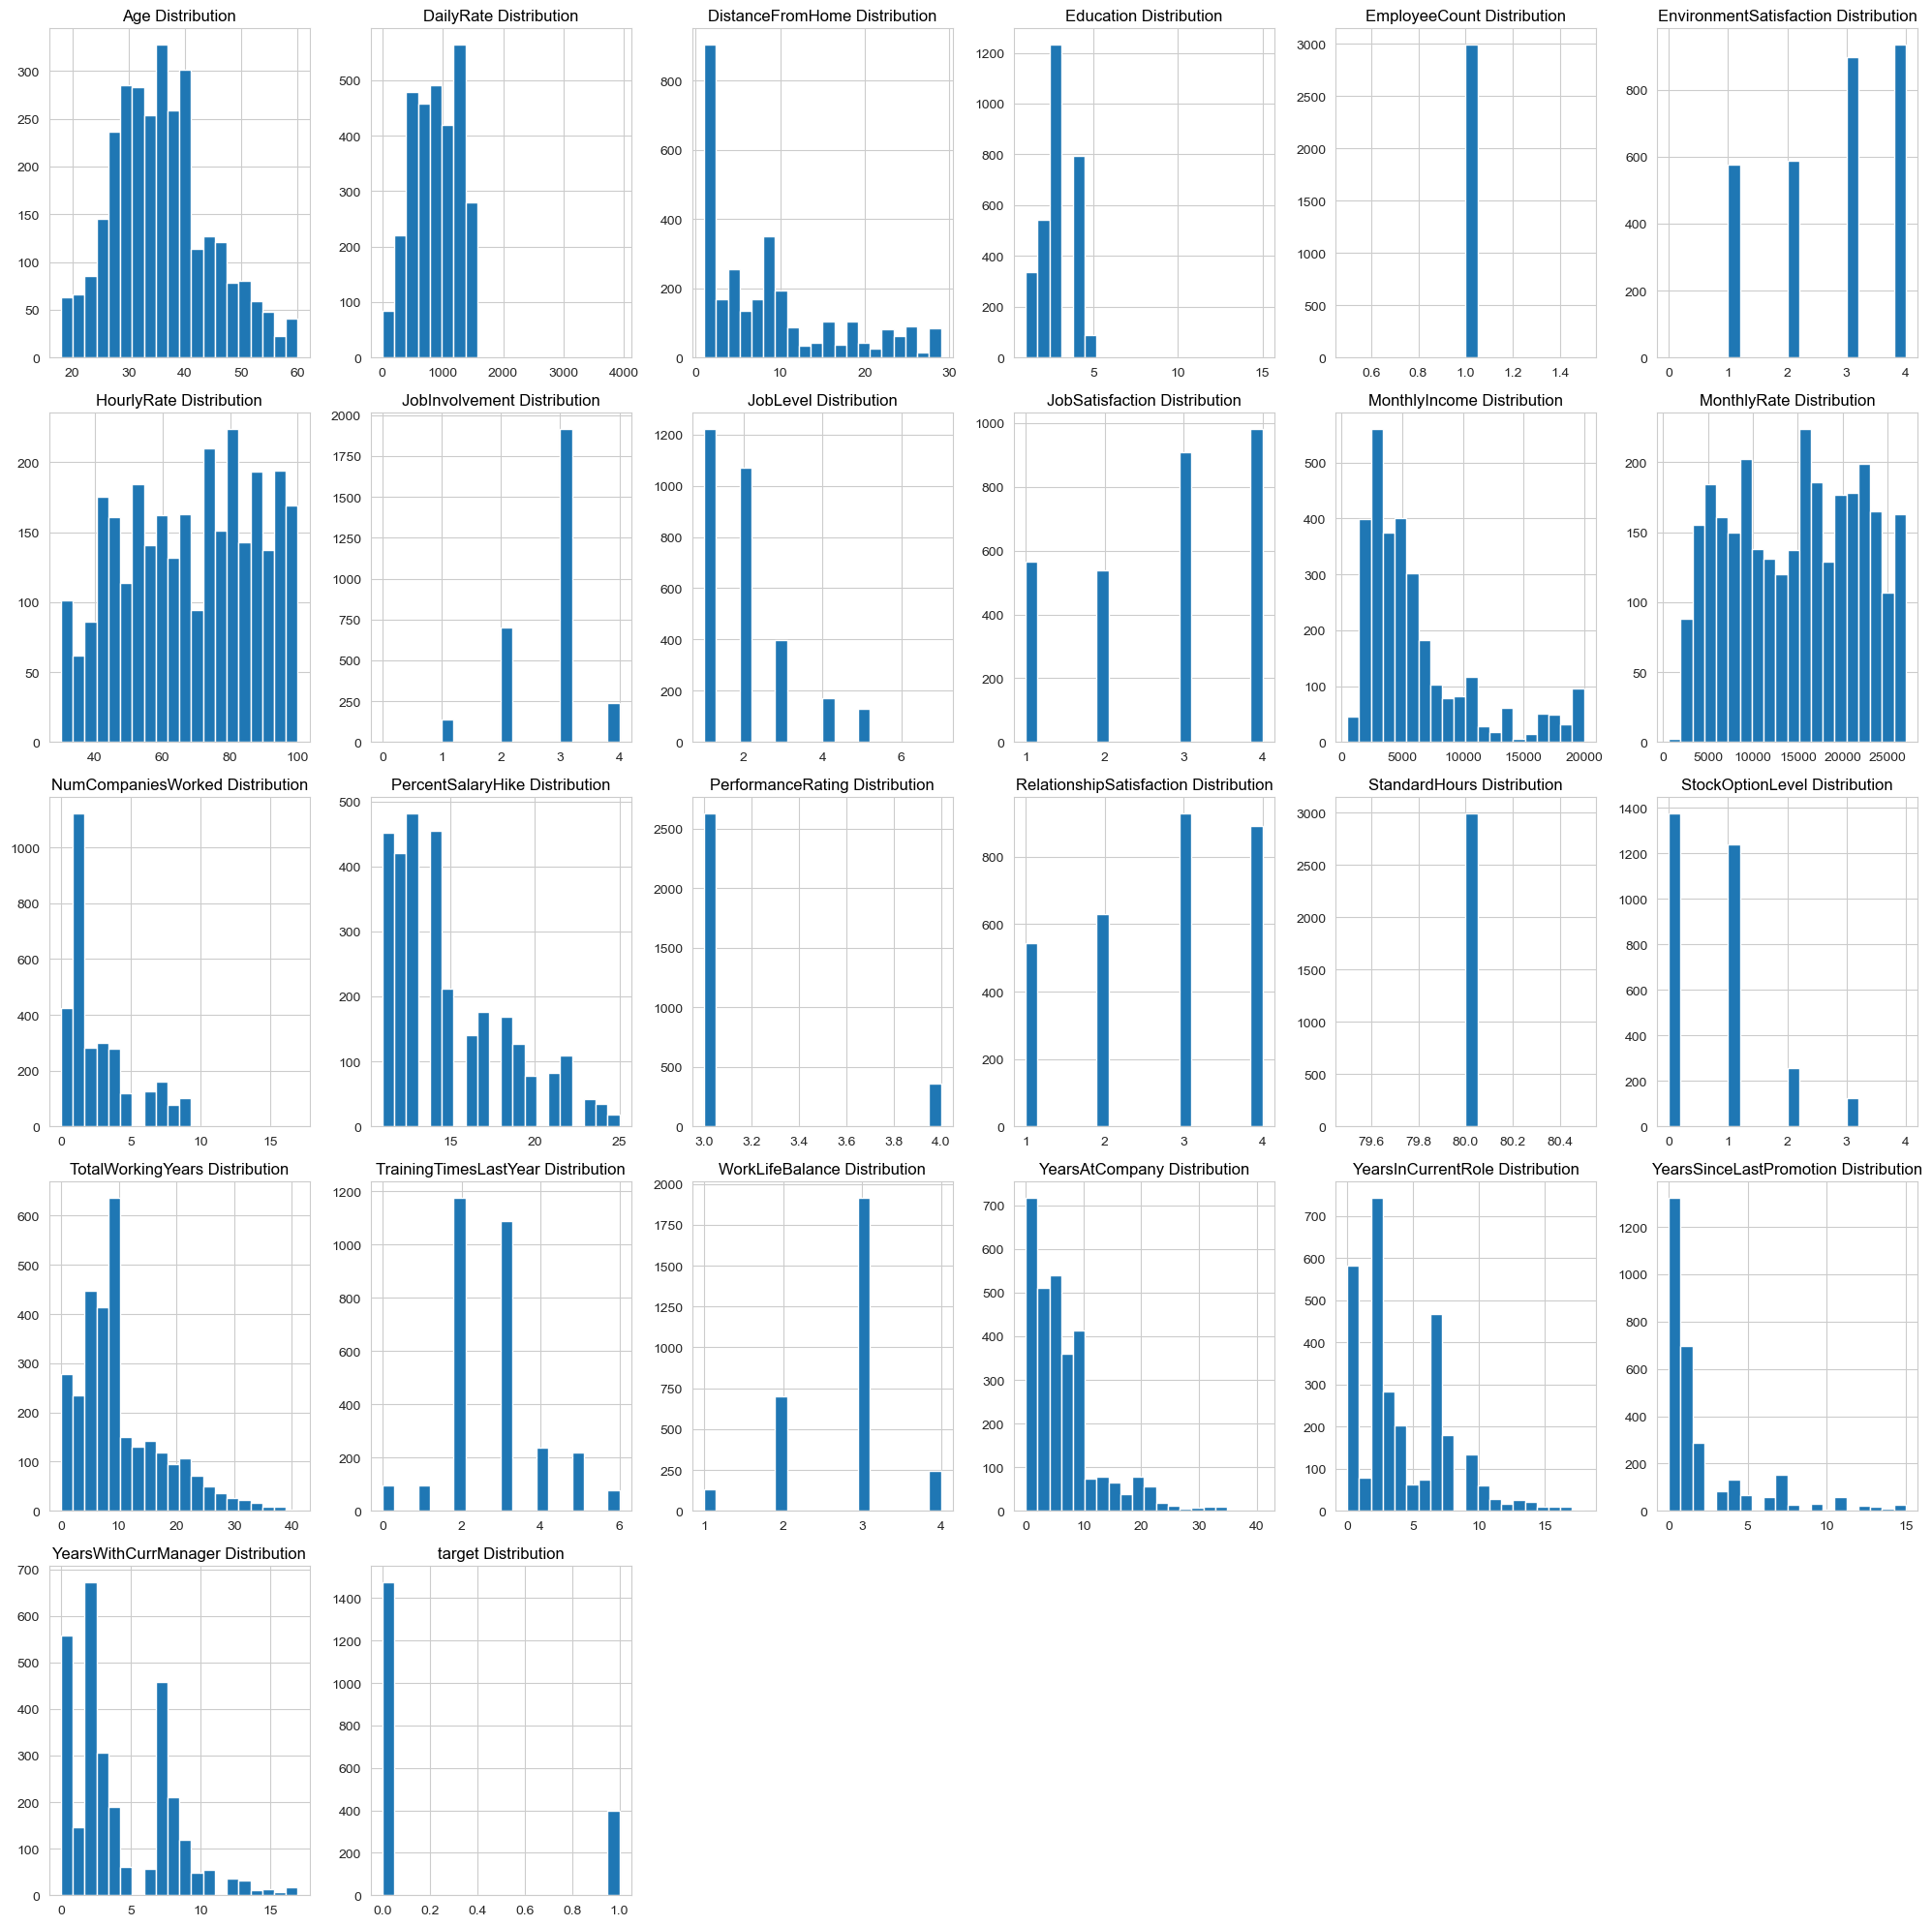

In [137]:
num_cols = df.select_dtypes(include=np.number)
histograms_plot(df, num_cols, 5, 6)

In [138]:
features = df.drop('target',axis=1).columns.to_list()

uniques = []
for f in features:
    item = {'feature':f}
    count = len(df[f].unique())
    item['unique'] = count
    if count < 10:
        item['values'] = df[f].unique().tolist()
    elif count < train.shape[0]:
        item['values'] = df[f].unique().tolist()[:10] + ['...']
    else:
        item['values'] = ['All values are unique']

    uniques.append(item)
df_uniques = pd.DataFrame(uniques)
df_uniques = df_uniques.set_index('feature')

df_uniques.style.background_gradient(subset=['unique'], cmap='Reds')

,unique,values
feature,,
Age,43,"[36, 35, 32, 38, 50, 27, 34, 40, 51, 25, '...']"
BusinessTravel,3,"['Travel_Frequently', 'Travel_Rarely', 'Non-Travel']"
DailyRate,734,"[599, 921, 718, 1488, 1017, 566, 944, 1009, 1297, 806, '...']"
Department,3,"['Research & Development', 'Sales', 'Human Resources']"
DistanceFromHome,29,"[24, 8, 26, 2, 5, 10, 6, 9, 28, 1, '...']"
Education,6,"[3, 4, 1, 2, 5, 15]"
EducationField,6,"['Medical', 'Other', 'Marketing', 'Life Sciences', 'Technical Degree', 'Human Resources']"
EmployeeCount,1,[1]
EnvironmentSatisfaction,5,"[4, 1, 3, 2, 0]"


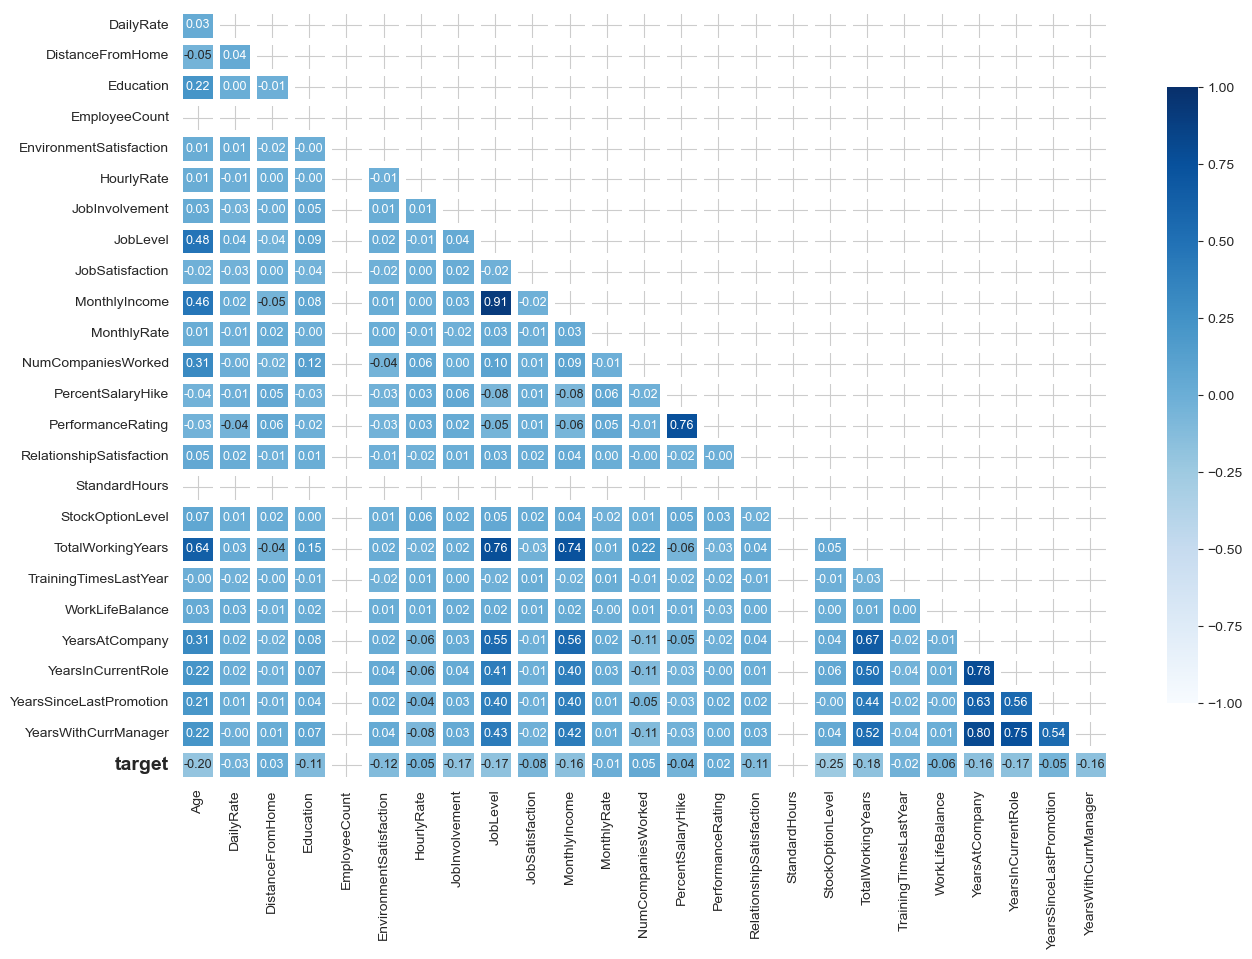

In [139]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 9}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

Columns EmployeeCount, EmployeeCount, StandardHours and only have 1 value, so I'm going to delete it.

In [140]:
df = df.drop(columns=['EmployeeCount','EmployeeCount','StandardHours'])

<a id="3"></a>
# <b>3 </b><b> <span style='color:#F1C40F'>|</span> Preprocessing</b>

In [141]:
def is_young(x):
    if x <=25:
        return 1
    else:
        return 0

def young_and_low_daily_rate(x):
    if x['Age'] <= 25 & x['DailyRate'] < 500:
        return 1
    else:
        return 0
    
df['is_young'] = df['Age'].apply(lambda x: is_young(x))
df['young_and_underpaid'] = df.apply(lambda x: young_and_low_daily_rate(x), axis = 1)
df['worklife_stock'] = df.apply(lambda x: x['WorkLifeBalance'] + x['StockOptionLevel'], axis = 1)

In [142]:
features = ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
            'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
            'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
            'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
            'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
            'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
            'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
            'YearsWithCurrManager','is_young', 'young_and_underpaid']

cat_features = ['BusinessTravel', 'Department','Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
                'JobInvolvement', 'JobLevel', 'JobRole',
                'JobSatisfaction', 'MaritalStatus','NumCompaniesWorked', 'OverTime', 
                'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
                'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
                'YearsAtCompany','is_young', 'young_and_underpaid']

In [143]:
woe = WOEEncoder(drop_invariant=True, randomized = True)
for col in cat_features:
    df[col] = df[col].astype(str)
woe.fit(df[features][:-len(test)], df['target'][:-len(test)], cols = cat_features)
X = woe.transform(df[features])
X['target'] = df['target']

y = df['target']

In [144]:
X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_young,young_and_underpaid,target
0,36,0.585540,599,-0.112838,24,0.141209,-0.041408,-0.339898,0.094733,42,-0.184977,0.572944,0.501726,-0.320535,-0.305349,2596,5099,0.278858,0.732616,13,-0.017733,-0.057308,-0.972136,-0.160761,0.027966,-0.053042,0.053996,0,7,8,-0.093166,-0.038178,0.0
1,35,-0.075809,921,0.204057,8,0.141209,-0.476187,0.510941,0.094733,46,-0.184977,0.572944,1.321718,0.280597,-0.305349,2899,10778,0.278858,-0.342565,17,-0.017733,-0.254943,-0.972136,0.424119,-0.039565,-0.053042,-0.092842,2,0,3,-0.093166,-0.038178,0.0
2,32,-0.075809,718,0.204057,26,0.141209,0.428774,-0.019656,0.094733,80,-0.184977,-0.610787,-0.115577,-0.320535,-0.943826,4627,16495,-0.739807,-0.342565,17,-0.017733,-0.254943,-0.999916,0.424119,-0.039565,-0.053042,-0.217156,2,1,2,-0.093166,-0.038178,0.0
3,38,-0.075809,1488,-0.112838,2,0.141209,-0.041408,-0.019656,-0.182565,40,-0.184977,-0.610787,-0.636415,0.280597,-0.305349,5347,13384,0.025809,-0.342565,14,-0.017733,-0.098728,0.666489,-0.003582,-1.741853,0.981762,-0.718276,0,0,2,-0.093166,-0.038178,0.0
4,50,-0.075809,1017,-0.112838,5,-0.410309,-0.041408,-0.026467,-0.182565,37,-0.184977,-0.562115,-0.387621,0.280597,0.596507,19033,19805,0.278858,0.732616,13,-0.017733,-0.098728,0.666489,0.204057,0.857984,-0.053042,1.014987,14,4,10,-0.093166,-0.038178,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,31,-0.075809,755,0.204057,1,0.532830,-0.054970,-0.019656,0.094733,81,0.251913,0.572944,1.321718,-0.320535,-0.943826,4678,9150,0.278858,-0.342565,12,-0.017733,-0.098728,-0.972136,1.200391,-1.741853,-0.053042,0.912613,0,0,0,-0.093166,-0.038178,NaN
1115,40,-0.075809,654,-0.112838,26,-0.849093,-0.041408,-0.019656,0.094733,96,0.251913,-0.610787,0.501726,-0.320535,-0.305349,6220,6409,0.278858,-0.342565,14,-0.017733,-0.254943,-0.972136,-0.966014,0.381512,-0.053042,-0.614253,10,1,8,-0.093166,-0.038178,NaN
1116,42,0.585540,884,-0.112838,1,-0.410309,-0.041408,-0.026467,-0.182565,65,-0.184977,-0.610787,-0.636415,0.280597,-0.305349,5238,6069,0.025809,-0.342565,17,-0.017733,0.532889,-0.972136,-0.160761,0.027966,-0.095321,-0.438271,3,0,2,-0.093166,-0.038178,NaN
1117,25,0.585540,1469,0.204057,1,-0.065343,0.137366,-0.019656,0.094733,68,0.251913,-0.610787,-0.115577,-0.320535,-0.305349,4799,17519,-0.739807,-0.342565,11,-0.017733,-0.254943,-0.972136,-0.207239,0.027966,-0.053042,-0.092842,2,1,3,0.745324,0.883959,NaN


In [145]:
res_col = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','PercentSalaryHike','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']

In [146]:
for r in res_col:
    vl = X[r].values
    vl = vl.reshape(-1,1)
    X[r] = quantile_transform(vl, n_quantiles=10, output_distribution='uniform')

In [147]:
len(X)

2996

In [148]:
train_df = X.iloc[:-len(test),:]
train_df['target'] = y[:-len(test)]
test_df = X.iloc[-len(test):,:].reset_index(drop=True)

X = train_df.drop(['target'], axis=1)
y = train_df.target
X_test = test_df

<a id="4"></a>
# <b>4 </b><b> <span style='color:#F1C40F'>|</span> Model</b>

In [149]:
n_folds = 10
repeats = 3
n_folds = 10

MAX_ITER = 15000
PATIENCE = 1000
DISPLAY_FREQ = 100

modelsCB = []
predsCB = []

In [150]:
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

MODEL_PARAMS = {
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
                'use_best_model': True,
                'eval_metric': 'AUC',
                'verbose': 1000,    
                 'depth': 3,
                 'learning_rate': 0.01, 
                 'rsm': 0.5,
                 'subsample': 0.931,
                 'l2_leaf_reg': 69, #69, 4.445
                 'min_data_in_leaf': 20, #20, 1
                 'random_strength': 0.175,
               }

for train_index, test_index in k_fold.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
    model_catboost = catboost.CatBoostRegressor(**MODEL_PARAMS)
    
    model_catboost.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE, verbose=0
         )
    predsCB.append(model_catboost.predict(X_test))

In [ ]:
model_catboost.predict(X_test)